In [1]:
import simpy, random
from queue_simulation import ServiceOperation, SIMULATION_DURATION, SEED

In [2]:
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Initializing OpenUp Queue Simulation')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

random.seed(SEED) # comment out line if not reproducing results
queue_exceeded = []
max_queue_length = []
num_helpseekers = []
num_helpseekers_served = []
num_helpseekers_served_g_regular = []
num_helpseekers_served_g_repeated = []
num_helpseekers_reneged = []
num_helpseekers_reneged_g_regular = []
num_helpseekers_reneged_g_repeated = []
num_available_counsellor_processes = []
    
for i in range(1, 1501):
    # create environment
    env = simpy.Environment() 

    # set up service operation and run simulation until  
    S = ServiceOperation(env=env)
    env.run(until=SIMULATION_DURATION)

#     print(f'Iteration #{i} ')
      
    num_helpseekers.append(S.num_helpseekers)
    max_queue_length.append(S.helpseeker_queue_max_length)
    queue_exceeded.extend(S.times_queue_exceeded_five_helpseekers)
    num_available_counsellor_processes.extend(S.num_available_counsellor_processes)
    num_helpseekers_served.append(S.served)
    num_helpseekers_served_g_regular.append(S.served_g_regular)
    num_helpseekers_served_g_repeated.append(S.served_g_repeated)
    num_helpseekers_reneged.append(S.reneged)
    num_helpseekers_reneged_g_regular.append(S.reneged_g_regular)
    num_helpseekers_reneged_g_repeated.append(S.reneged_g_repeated)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Initializing OpenUp Queue Simulation
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
sns.set();

In [5]:
num_helpseekers = pd.Series(num_helpseekers, name='number of helpseekers')
num_helpseekers_served = pd.Series(num_helpseekers_served, name='number of helpseekers served')
num_helpseekers_served_g_regular = pd.Series(num_helpseekers_served_g_regular, name='number of users served')
num_helpseekers_served_g_repeated = pd.Series(num_helpseekers_served_g_repeated, name='number of repeated users served')
num_helpseekers_reneged = pd.Series(num_helpseekers_reneged, name='number of helpseekers reneged')
num_helpseekers_reneged_g_regular = pd.Series(num_helpseekers_reneged_g_regular, name='number of users reneged')
num_helpseekers_reneged_g_repeated = pd.Series(num_helpseekers_reneged_g_repeated, name='number of repeated users reneged')
# queue_exceeded = pd.Series(queue_exceeded, name='number of instances queue exceeded four helpseekers')
max_queue_length = pd.Series(max_queue_length, name='max queue length')

In [6]:
# function to calculate classification confidence intervals
# parameter: stats - list of confidence intervals, which must be ordered
#            metadata - any string to annotate printout, can be None
# precondition - metadata must be a string or None, and stats must be a list
#                  The check is commented out for now as asserts should 
#               be done outside function
# returns: cutoff values at 2.5% and 95% percentiles
def calculate_confidence_intervals(stats, metadata=None):
    # if not isinstance(metadata, None) or \
    #     not isinstance(metadata, str) or \
    #     not isinstance(stats, list):
    #     return
        
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(stats, q_lower)
    upper_percentile = np.percentile(stats, q_upper)
    mean = np.mean(stats)
        
    print('\n%s %d%% Confidence interval:' % (
        metadata, confidence_interval) )
    print('----------------------------')
    print('%.1f%% percentile: %.5f' % (q_lower, lower_percentile) )
    print('%.1f%% percentile: %.5f\n' % (q_upper, upper_percentile) )
    print('mean value: %.5f' % mean)
    return (lower_percentile, upper_percentile, mean)

In [7]:
import matplotlib.pyplot as plt

In [8]:
def plot_distribution(series, filename):
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(series, q_lower)
    upper_percentile = np.percentile(series, q_upper)
    mean = np.mean(series)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5) )
    sns.distplot(series, ax=ax)
    ax.axvline(x=lower_percentile, linestyle='--' )
    ax.axvline(x=upper_percentile, linestyle='--' )
    ax.axvline(x=mean, linestyle=':', linewidth=2 )
    
    fig.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')

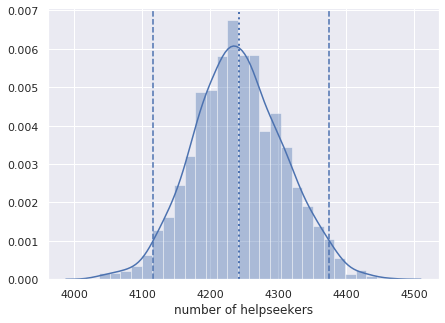

In [9]:
plot_distribution(num_helpseekers, 'num_helpseekers')

In [10]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 4115.47500
97.5% percentile: 4374.05000

mean value: 4241.49000


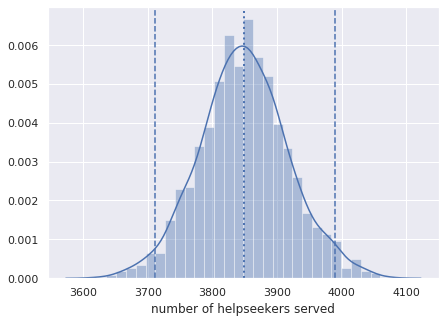

In [11]:
plot_distribution(num_helpseekers_served, 'num_helpseekers_served')

In [12]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers_served.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 3712.00000
97.5% percentile: 3989.00000

mean value: 3849.09267


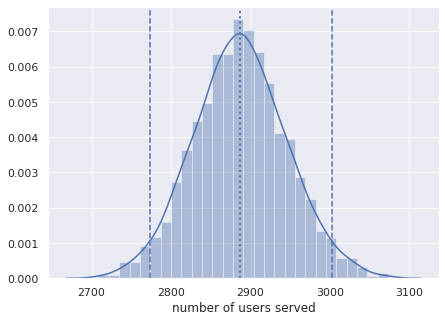

In [13]:
plot_distribution(num_helpseekers_served_g_regular, 'num_helpseekers_served_g_regular')

In [14]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers_served_g_regular.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 2773.00000
97.5% percentile: 3003.00000

mean value: 2887.05200


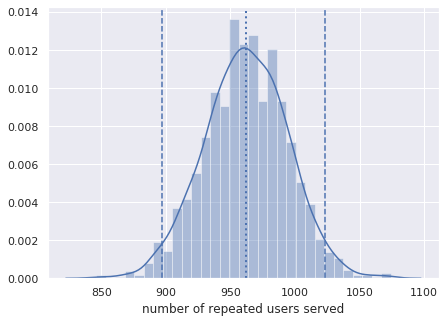

In [15]:
plot_distribution(num_helpseekers_served_g_repeated, 'num_helpseekers_served_g_repeated')

In [16]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers_served_g_repeated.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 897.00000
97.5% percentile: 1023.00000

mean value: 962.04067


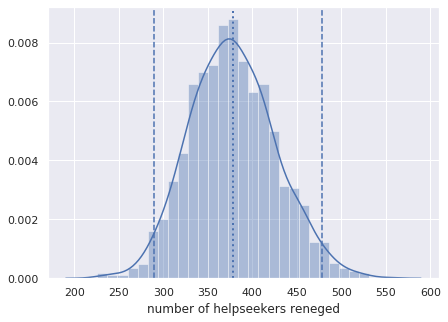

In [17]:
plot_distribution(num_helpseekers_reneged, 'num_helpseekers_reneged')

In [18]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers_reneged.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 290.00000
97.5% percentile: 478.00000

mean value: 378.33733


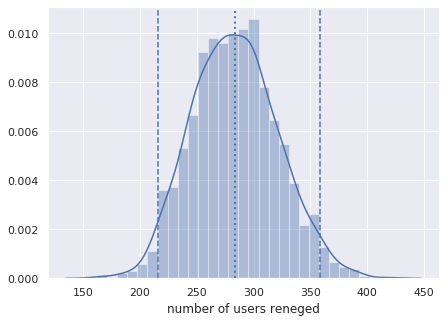

In [19]:
plot_distribution(num_helpseekers_reneged_g_regular, 'num_helpseekers_reneged_g_regular')

In [20]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers_reneged_g_regular.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 216.00000
97.5% percentile: 358.52500

mean value: 283.52600


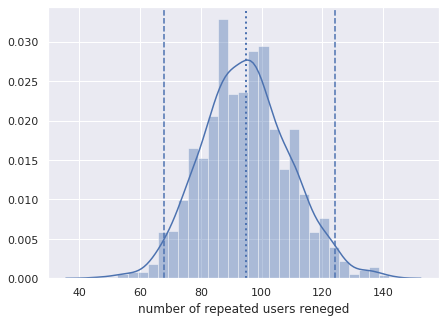

In [21]:
plot_distribution(num_helpseekers_reneged_g_repeated, 'num_helpseekers_reneged_g_repeated')

In [22]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers_reneged_g_repeated.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 68.00000
97.5% percentile: 124.00000

mean value: 94.81133


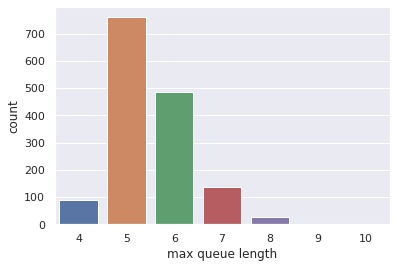

In [23]:
max_queue_length_count = sns.countplot(x='max queue length', data=max_queue_length.to_frame())

max_queue_length_count.get_figure().savefig(f'max_queue_length_count.png', dpi=300, bbox_inches='tight')

In [24]:
queue_exceeded

[('weekday:0', 'hour:22'),
 ('weekday:0', 'hour:22'),
 ('weekday:0', 'hour:23'),
 ('weekday:0', 'hour:23'),
 ('weekday:0', 'hour:19'),
 ('weekday:0', 'hour:20'),
 ('weekday:1', 'hour:23'),
 ('weekday:1', 'hour:23'),
 ('weekday:1', 'hour:18'),
 ('weekday:1', 'hour:19'),
 ('weekday:1', 'hour:0'),
 ('weekday:1', 'hour:20'),
 ('weekday:1', 'hour:20'),
 ('weekday:1', 'hour:0'),
 ('weekday:0', 'hour:0'),
 ('weekday:0', 'hour:1'),
 ('weekday:2', 'hour:22'),
 ('weekday:0', 'hour:18'),
 ('weekday:1', 'hour:22'),
 ('weekday:1', 'hour:22'),
 ('weekday:0', 'hour:23'),
 ('weekday:2', 'hour:1'),
 ('weekday:0', 'hour:23'),
 ('weekday:0', 'hour:23'),
 ('weekday:0', 'hour:22'),
 ('weekday:1', 'hour:0'),
 ('weekday:1', 'hour:0'),
 ('weekday:2', 'hour:0'),
 ('weekday:2', 'hour:0'),
 ('weekday:2', 'hour:0'),
 ('weekday:0', 'hour:19'),
 ('weekday:1', 'hour:21'),
 ('weekday:1', 'hour:21'),
 ('weekday:1', 'hour:23'),
 ('weekday:0', 'hour:23'),
 ('weekday:0', 'hour:23'),
 ('weekday:0', 'hour:0'),
 ('weekday:6

In [25]:
queue_exceeded = pd.DataFrame(queue_exceeded, columns=['day_of_week', 'hour'])

In [26]:
queue_exceeded['hour'] = queue_exceeded['hour'].str.replace('hour:', '').astype(int)

In [27]:
queue_exceeded['day_of_week'].replace({
    'weekday:0': 'Sunday',
    'weekday:1': 'Monday',
    'weekday:2': 'Tuesday',
    'weekday:3': 'Wednesday',
    'weekday:4': 'Thursday',
    'weekday:5': 'Friday',
    'weekday:6': 'Saturday'
}, inplace=True)

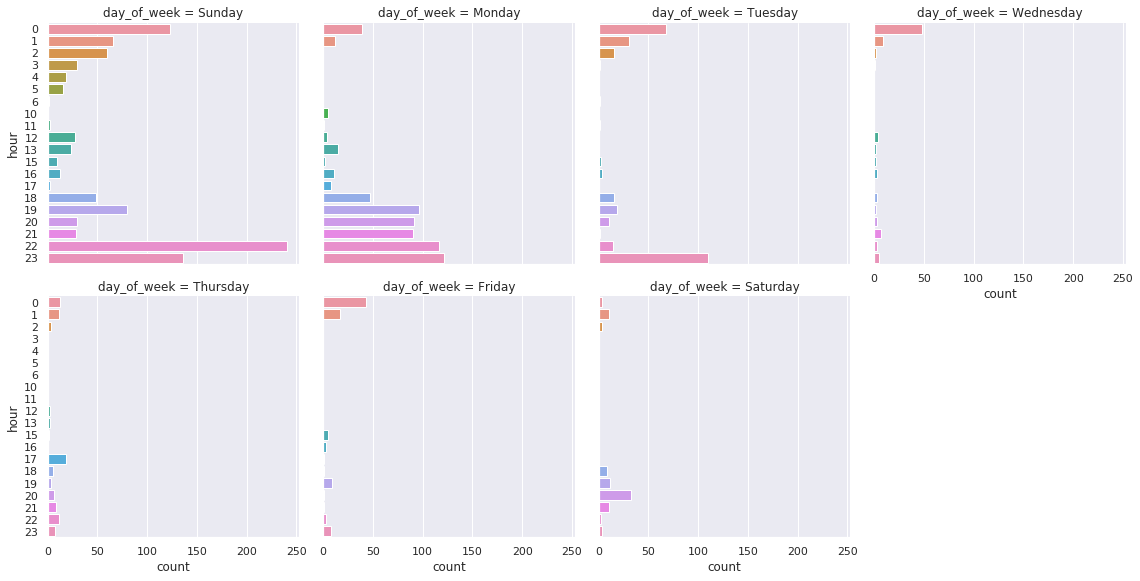

In [28]:
queue_plot = sns.catplot(col='day_of_week', y='hour', col_wrap=4,
    col_order=['Sunday',
        'Monday',
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday'],
    data=queue_exceeded, kind="count",
    height=4, aspect=1);
queue_plot.savefig(f'queue_blowup.png', dpi=300, bbox_inches='tight')

# determine hours counsellors are maxed out

In [ ]:
df2 = pd.DataFrame(num_available_counsellor_processes, columns=['time', 'num_counsellor_processes'])

In [ ]:
from queue_simulation import MINUTES_PER_DAY, DAYS_IN_WEEK, MINUTES_PER_HOUR#, MAX_NUM_SIMULTANEOUS_CHATS

In [ ]:
df2['time_int'] = df2['time'].astype(int)

In [ ]:
df2['current_day_minutes'] = df2['time_int'] % MINUTES_PER_DAY

In [ ]:
df2['weekday'] = (df2['time_int'] / MINUTES_PER_DAY).astype(int) % DAYS_IN_WEEK

In [ ]:
df2['hour'] = (df2['current_day_minutes'] / MINUTES_PER_HOUR).astype(int)

In [ ]:
df2['day_of_week'] = df2['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
})

# Number of instances when one/no counsellor is available (1500 simulations, seed=728, four or less processes)

In [ ]:
process_plot = sns.catplot(col='day_of_week', y='hour', col_wrap=4,
    col_order=['Sunday',
        'Monday',
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday'],
    data=df2[df2['num_counsellor_processes']<=2], kind="count",
    height=4, aspect=1);
process_plot.savefig(f'process_plot.png', dpi=300, bbox_inches='tight')

# Number of instances when at least two counsellors are idle (1500 simulations, seed=728, eight or more processes)

In [ ]:
process_plot = sns.catplot(col='day_of_week', y='hour', col_wrap=4,
    col_order=['Sunday',
        'Monday',
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday'],
    data=df2[df2['num_counsellor_processes']>=8], kind="count",
    height=4, aspect=1);
process_plot.savefig(f'process_plot_2.png', dpi=300, bbox_inches='tight')